In [ ]:
# Append src directory to path
import sys
sys.path.append('C:\\Users\\kingt\\Dropbox\\Programming\\NeuralSimV3\\NeuroSimV3\\python\\src')

In [886]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [887]:
import numpy as np
import matplotlib.pyplot as plt

from neuron_population import NeuronPopulation
from connectome import Connectome
from overhead import Simulation
import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree
from neuron_templates import neuron_type_IZ
from network_grower import *

In [888]:
dt = 0.1

# Grow graph

In [889]:
n_layers = 3
distances = [1.1, 0.2]  # Distances between layers
thicknesses = [0.4, 0.4, 0.4]  # Thickness of each layer

layer_boundaries  = generate_linear_boundaries(n_layers, distances, thicknesses, flow_direction="z", cross_dimensions=(0.5, 0.5))

N = 70
out_max = 20
alpha_init = 12.0

# These are relative layer densities
layer_densities = np.ones(n_layers)
layer_densities[0] = 20
layer_densities[1] = 25
layer_densities[2] = 25

G_directed, coords, neurons_per_layer = phase1_spatial_growth(N, layer_boundaries, layer_densities, out_max, alpha_init)

In [890]:
def flow_vector(coords):
    """
    Generate a flow vector for long-range connections.
    coords: coordinates of neurons 
    """
    return np.array([0.0, 0.0, -1.0])  # Example flow vector pointing downwards


type_distribution = np.array([[0.5, 0.2, 0.0, 0.3], 
                              [0.5, 0.2, 0.15, 0.15],
                              [0.5, 0.2, 0.15, 0.15]])  # Distribution of neuron types
# type_distribution = np.array([0.5, 0.2, 0.15, 0.15])  # Distribution of neuron types
alpha_type_local = np.array([15, 15, 15, 15])  # Distance scale parameters for each type
alpha_type_global = np.array([15, 15, 15, 15])  # Distance scale parameters for each type
thalamus_layer = 0  # Index of the thalamus layer in layer_bounds

# Phase 2:
G_directed, coords, neurons_per_layer = phase2_spatial_growth(G_directed, coords, neurons_per_layer, 
                                                              out_max, flow_vector, type_distribution, 
                                                              alpha_type_local, alpha_type_global,
                                                              thalamus_layer=thalamus_layer) 

10 20
12 25
12 25


In [891]:
len(type_distribution.shape)

2

## Small world?

In [892]:
# check_small_world(G_directed, n_tests=1)

## Heavy tail?

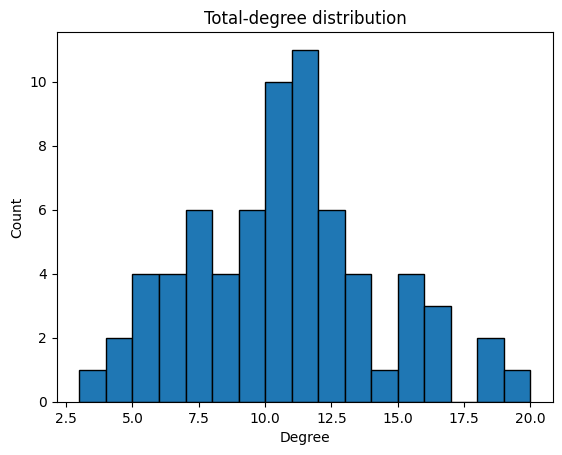

In [893]:
_in, _out, _tot = plot_connections_histogram(G_directed)

## Plot

In [894]:
plot_connections(G_directed, coords, "phase2.html")

phase2.html


# Graph to connectome

In [895]:
class1_type_dist = [("p23", 0.5, [0, 0, 1]), ("p5_p6", 0.5, [0, 1, 0]), ("TC", 1, [1, 0, 0])]  # Global excitatory neuron types
class2_type_dist = [("ss4", 1, [0, 1, 1]), ("TC", 1, [1, 0, 0])]  # Local excitatory neuron types
class3_type_dist = [("nb1", 0.5, [0, 0, 1]), ("nb", 0.5, [0, 1, 0])]  # Global inhibitory neuron types
class4_type_dist = [("b", 1, [0, 1, 1]), ("TRN", 1, [1, 0, 0]), ("TI", 1.0, [1, 0, 0])]  # Local inhibitory neuron types
# class3_type_dist = [("nb1", 0.5, [0, 0, 1]), ("nb", 0.5, [0, 1, 0]), ("TI", 1.0, [1, 0, 0])]  # Global inhibitory neuron types
# class4_type_dist = [("b", 1, [0, 1, 1]), ("TRN", 1, [1, 0, 0])]  # Local inhibitory neuron types

threshold_decay = np.exp(-dt / 5)
neuron_pop, connectome = neuron_pop_and_connectome_from_graph(G_directed, neurons_per_layer,
                                         class1_type_dist=class1_type_dist, class2_type_dist=class2_type_dist,
                                            class3_type_dist=class3_type_dist, class4_type_dist=class4_type_dist,
                                            threshold_decay=threshold_decay)

c:\Users\kingt\Dropbox\Programming\NeuralSimV3\NeuroSimV3\python\src\network_grower.py:560: RuntimeWarning: invalid value encountered in divide
  class2_probs /= np.sum(class2_probs)  # Normalize probabilities


In [896]:
# Save neuron_pop and connectome

import pickle
import time

save = False
# save = True

if save:
    name = f"good_learning1_{int(time.time())}"

    with open(f"saved_networks/{name}_neuron_pop.pickle", "wb") as f:
        pickle.dump(neuron_pop, f)

    with open(f"saved_networks/{name}_connectome.pickle", "wb") as f:
        pickle.dump(connectome, f)

In [897]:
neuron_types = neuron_pop.neuron_population_types
# Get indices of all "TC" neurons (only want to input into these neurons)
TC_indices = [i for i, neuron in enumerate(neuron_types) if neuron == "TC"]
# Only want to do any input into half of the TC neurons
TC_indices = random.sample(TC_indices, len(TC_indices) // 2)
TC_indices

[18, 2, 17, 15, 0, 11, 9]

# Simulate

In [898]:
sim = Simulation(connectome, dt, stepper_type="adapt")
connectome.set_random_weights()
# sim.plasticity.mirror_neurons = [(0, -2), (1, -1)]

In [899]:
I_ext = np.zeros((neuron_pop.n_neurons))

# Input into half of the selected TC neurons
TC_first_half = TC_indices[:len(TC_indices) // 2]
I_ext[TC_first_half] = 150
I_ext[neuron_pop.get_neurons_from_layer(1)] = 75
I_ext[neuron_pop.get_neurons_from_layer(2)] = 75

for i in range(40000):
    sim.step(I_ext=I_ext)

weights_t1 = connectome.W.copy()

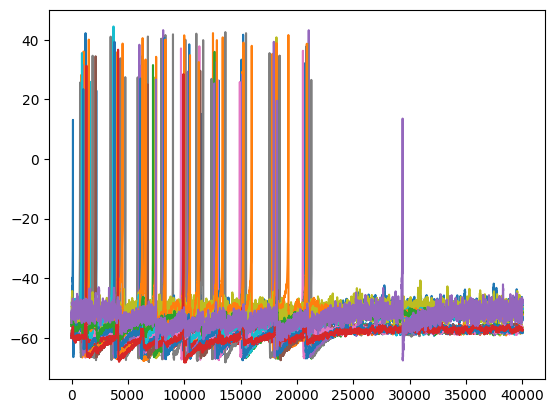

In [900]:
plt.plot(np.array(sim.stats.Vs)[:, neuron_pop.get_neurons_from_layer(1)])
plt.show()

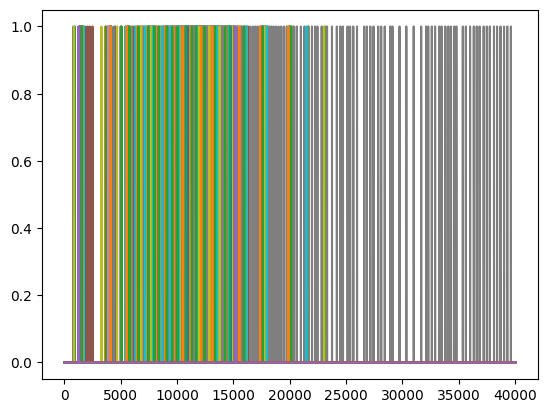

In [901]:
plt.plot(np.array(sim.stats.spikes)[:, neuron_pop.get_neurons_from_layer(2)])
plt.show()

In [902]:
total_spikes = np.array(sim.stats.spikes).sum(axis=0)
# Sort neurons by total spikes, and keep the indices
sorted_indices = np.argsort(total_spikes)[::-1]
sorted_neurons = [neuron_pop.neuron_population_types[i] for i in sorted_indices]
sorted_layer_idxs = [neuron_pop.get_layer(i) for i in sorted_indices]

# Combine sorted_indices, sorted_neurons, and sorted_layer_idxs into a single list of tuples
sorted_neurons_info = list(zip(sorted_indices, sorted_neurons, sorted_layer_idxs, total_spikes[sorted_indices]))
# Print the sorted neurons information
for idx, neuron_type, layer_idx, tot_spikes in sorted_neurons_info:
    print(f"Index: {idx}, Type: {neuron_type}, Layer: {layer_idx}, Total Spikes: {tot_spikes}")

Index: 2, Type: TC, Layer: 0, Total Spikes: 235
Index: 18, Type: TC, Layer: 0, Total Spikes: 213
Index: 62, Type: nb1, Layer: 2, Total Spikes: 203
Index: 17, Type: TC, Layer: 0, Total Spikes: 194
Index: 6, Type: TC, Layer: 0, Total Spikes: 178
Index: 15, Type: TC, Layer: 0, Total Spikes: 138
Index: 16, Type: TC, Layer: 0, Total Spikes: 136
Index: 11, Type: TC, Layer: 0, Total Spikes: 132
Index: 0, Type: TC, Layer: 0, Total Spikes: 117
Index: 9, Type: TC, Layer: 0, Total Spikes: 111
Index: 8, Type: TC, Layer: 0, Total Spikes: 89
Index: 19, Type: TI, Layer: 0, Total Spikes: 69
Index: 60, Type: nb1, Layer: 2, Total Spikes: 28
Index: 67, Type: b, Layer: 2, Total Spikes: 21
Index: 7, Type: TRN, Layer: 0, Total Spikes: 21
Index: 63, Type: ss4, Layer: 2, Total Spikes: 18
Index: 64, Type: p23, Layer: 2, Total Spikes: 17
Index: 66, Type: p23, Layer: 2, Total Spikes: 16
Index: 41, Type: nb, Layer: 1, Total Spikes: 16
Index: 56, Type: p23, Layer: 2, Total Spikes: 15
Index: 27, Type: p5_p6, Layer: